# Benson Challenge

In [1]:
import sys
print("Python Version:", sys.version)
import pandas as pd

Python Version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## Challenge 1

In [1]:
#please download the three files in the data_date list starting from "190608". This cleaning algorithm cannot deal with data covering
#different month since "day" is a key which gets filtered during cleaning. Modification needed to take more data files.
import pandas as pd

def csv_to_df(data_date):
    csv_file = "turnstile_{}.txt"
    dfs = []
    for date in data_date:
        data_file = csv_file.format(date)
        dfs.append(pd.read_csv(data_file))
    return pd.concat(dfs)

data_date = ["190608", "190615", "190622"]
df = csv_to_df(data_date)

FileNotFoundError: [Errno 2] File b'turnstile_190608.txt' does not exist: b'turnstile_190608.txt'

### checking data frame

In [3]:
#df.head()
#df.tail()
#df.info()

### Clean column names

In [4]:
def rename_columns():
    column_names = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES','EXITS']
    df.columns = [x.lower() for x in column_names]
rename_columns()

### checking unique elements

In [62]:
#df.groupby("time").time.count().sort_values(ascending = False)
#00: and 01: already comprise of 90% of the data! 10% of turnstiles don't submit the first data around midnight!
#df.groupby("date").date.count()
#df.entries.sort_values()

# Challenge 2

In [6]:
import dateutil.parser
from datetime import date

def produce_day_hour_column():
    par_funct = lambda row: dateutil.parser.parse(row["date"] + " " + row["time"])
    df["datetime"] = df.apply(par_funct, axis = 1)
    df["day"] = [x.day for x in df.datetime]
    df["hour"] = [x.hour for x in df.datetime]
produce_day_hour_column()

# Challenge 3

In [7]:
turnstile_id = ["c/a", "unit", "scp", "station"]
turnstile_id_day = turnstile_id + ["day"]

### checking everything

In [8]:
#df.groupby(turnstile_id).entries.count()
#df.groupby(turnstile_id_day).entries.count().sort_values()
#entry_and_time_col = ["entries", "day", "hour"]
#df.groupby(turnstile_id_day).hour.min().value_counts()
#dump all the data that starts after 4am (only 1 percent of total data)

In [9]:
#mask_test = ((df["c/a"] == "PTH18") & (df["unit"] == "R549") & (df["scp"] == "01-01-03") & (df["station"] == "NEWARK BM BW"))
#df[mask_test & (df.day == 12)]

In [63]:
# are all the cumulative entry counts integers? If function returns nan, cleaning algorithm will be needed
def integer_check():
    for i, value in enumerate(df.entries):
        if type(value) != int:
            print(value)
        elif i == len(df.entries) - 1:
            print("all are int!")
integer_check()

all are int!


# Drop duplicate to keep the earilest data each day

In [84]:
def keep_earliest_hour():
    df1 = df.sort_values('hour', ascending=True).drop_duplicates(turnstile_id_day)
    return df1.sort_values(turnstile_id_day).reset_index(drop=True)
df_keep_earliest_hour = keep_earliest_hour()

In [91]:
#df_keep_earliest_hour is the daily cumulative count
#df_keep_earliest_hour.hour.value_counts()
#now drop the rows recorded after 4am
#df_keep_earliest_hour.tail()

### drop data after 4am

In [92]:
#some turnstiles submit the first data of each day at noon, we can't do the daily count based on them.
def keep_midnight():
    return df_keep_earliest_hour[df_keep_earliest_hour.hour < 4].reset_index(drop=True)
df_keep_midnight = keep_midnight()
#df_keep_midnight.hour.value_counts()
#df_keep_midnight.head()

### checking if turnstiles all have 21 days of data

In [87]:
#df_keep_midnight.groupby(turnstile_id).entries.count().value_counts()
# 5% of the data has missing day, if wednesday is missing, we might have 
#Wednesday_daily_count = Thursday_cumulative_count - Tuesday_cumulative_count, more cleaning needed!

# Filter rows with less than 21 days of data
### filter rows by results of groupby!

In [93]:
def filter_day_span():
    return df_keep_midnight.groupby(turnstile_id).filter(lambda x: x["entries"].count() > 20).reset_index(drop=True)
df_filter_day_span = filter_day_span()

In [125]:
#df_filter_day_span.head()
#checking the day span is correct
#df_filter_day_span.groupby(turnstile_id).entries.count().value_counts()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,hour
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,00:00:00,REGULAR,7080105,2398899,2019-06-01,1,0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2019,00:00:00,REGULAR,7081001,2399154,2019-06-02,2,0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/03/2019,00:00:00,REGULAR,7081661,2399345,2019-06-03,3,0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/04/2019,00:00:00,REGULAR,7083157,2399747,2019-06-04,4,0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2019,00:00:00,REGULAR,7084813,2400180,2019-06-05,5,0


# Check the cleaning process again

In [114]:
#df_filter_day_span.info()
#df_filter_day_span.tail()
#df_filter_day_span.columns
#df_filter_day_span.sample(n = 5, random_state= 41)
#df_filter_day_span.hour.value_counts()
#df_filter_day_span.groupby(turnstile_id).day.count().value_counts()
#df_filter_day_span.entries.max()
#2 billions almost equals to 2 ** 31 , is there a upper limit at which cumulative count got resetted?

# Daily entries count

In [131]:
def order_by_day():
    return df_filter_day_span.sort_values(turnstile_id_day).reset_index(drop = True)
df_order_by_day = order_by_day()
#df_order_by_day.count()

In [137]:
#produce subframe to compute the daily entries, then concatenate to the original dataframe
def diff_daily_count():
    df_sub = df_filter_day_span[["entries"]]
    df_daily_count = df_sub.diff()
    df_daily_count.columns = ["daily_count"]
    return pd.concat([df_order_by_day, df_daily_count], axis=1).reset_index(drop=True)
df_diff_daily_count = diff_daily_count()
#df_diff_daily_count.head()

### add previous day 

In [144]:
def add_prev_day():
    df_day = df_diff_daily_count[["date"]]
    df_day_shifted = df_day.shift()
    df_day_shifted.columns = ["prev_date"]
    return pd.concat([df_diff_daily_count, df_day_shifted], axis=1)
df_add_prev_day = add_prev_day()
#df_add_prev_day.head()

### subtraction produces nan, drop the first day!

In [147]:
def drop_first_day():
    return df_add_prev_day[(df_add_prev_day.day != 1)].reset_index(drop=True)
turnstile_df = drop_first_day()

# drop positive and negative outliers in daily_entry column

In [161]:
def functioning_turnstile_count_by_day():
    for n in range(2, 22):
        print(turnstile_df[(turnstile_df.day == n)].daily_count.count())
#functioning_turnstile_count_by_day()
#all the remaining turnstiles records data during the time span

In [183]:
#turnstile_df[(turnstile_df.daily_count > 20000)]
#1.8 billion of people went through a turnstile machine in one day?! That's 4 times the US population!

In [184]:
#by looking at the busiest stations we set the daily count upper bound to 20000
max_daily_cap = 20000
def drop_positive_outlier():
    return turnstile_df.groupby(turnstile_id).filter(lambda x: x['daily_count'].max()< max_daily_cap).reset_index(drop=True)
df_drop_p_outlier = drop_positive_outlier()

In [185]:

#df_drop_p_outlier[(df_drop_p_outlier.daily_count >max_daily_cap)]
#df_drop_p_outlier[(df_drop_p_outlier.daily_count < 0 )]

In [186]:
#now drop the neqative data, and the remaining data is sparkling clean!
def cleaned_data():
    return df_drop_p_outlier.groupby(turnstile_id).filter(lambda x: x['daily_count'].min() > 0).reset_index(drop=True)
df_cleaned = cleaned_data()
#df_cleaned[(df_cleaned.daily_count < 0)]

# Challenge 4

In [188]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

mask = ((df_cleaned["c/a"] == "A002") & 
(df_cleaned["unit"] == "R051") & 
(df_cleaned["scp"] == "02-00-00") & 
(df_cleaned["station"] == "59 ST"))
# datetime is both name of module and name of constructor of datetime object
df_cleaned[mask]

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,hour,daily_count,prev_date
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2019,00:00:00,REGULAR,7081001,2399154,2019-06-02,2,0,896.0,06/01/2019
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/03/2019,00:00:00,REGULAR,7081661,2399345,2019-06-03,3,0,660.0,06/02/2019
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/04/2019,00:00:00,REGULAR,7083157,2399747,2019-06-04,4,0,1496.0,06/03/2019
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2019,00:00:00,REGULAR,7084813,2400180,2019-06-05,5,0,1656.0,06/04/2019
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/06/2019,00:00:00,REGULAR,7086363,2400727,2019-06-06,6,0,1550.0,06/05/2019
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/07/2019,00:00:00,REGULAR,7087917,2401244,2019-06-07,7,0,1554.0,06/06/2019
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,00:00:00,REGULAR,7089463,2401758,2019-06-08,8,0,1546.0,06/07/2019
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/09/2019,00:00:00,REGULAR,7090281,2402005,2019-06-09,9,0,818.0,06/08/2019
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2019,00:00:00,REGULAR,7091020,2402182,2019-06-10,10,0,739.0,06/09/2019
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/11/2019,00:00:00,REGULAR,7092450,2402667,2019-06-11,11,0,1430.0,06/10/2019


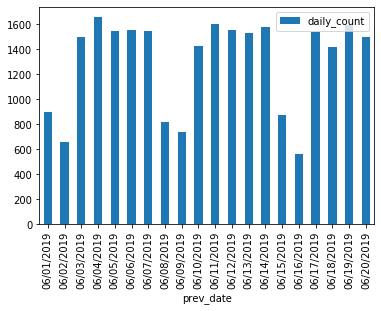

In [189]:
ax = df_cleaned[mask].plot.bar(x='prev_date', y='daily_count', rot=90)
ax = df_cleaned[mask].plot.bar

In [190]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66380 entries, 0 to 66379
Data columns (total 16 columns):
c/a            66380 non-null object
unit           66380 non-null object
scp            66380 non-null object
station        66380 non-null object
linename       66380 non-null object
division       66380 non-null object
date           66380 non-null object
time           66380 non-null object
desc           66380 non-null object
entries        66380 non-null int64
exits          66380 non-null int64
datetime       66380 non-null datetime64[ns]
day            66380 non-null int64
hour           66380 non-null int64
daily_count    66380 non-null float64
prev_date      66380 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(10)
memory usage: 8.1+ MB
